In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# For SQL in Colab
import sqlite3

In [13]:
#load dataset
import pandas as pd
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
# Check how many rows and columns are really in your dataset
print("Number of customers:", df.shape[0])
print("Number of features:", df.shape[1])

Number of customers: 7043
Number of features: 21


In [15]:
# Connect to in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Load DataFrame into SQL
df.to_sql('customer_data', conn, index=False, if_exists='replace')

7043

In [16]:
#sql examples
# Churn Rate
query = "SELECT AVG(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) AS ChurnRate FROM customer_data;"
pd.read_sql(query, conn)

# Revenue at Risk
query = "SELECT SUM(MonthlyCharges) AS RevenueAtRisk FROM customer_data WHERE Churn='Yes';"
pd.read_sql(query, conn)

# High-Value Churn Customers
query = """
SELECT customerID, MonthlyCharges, tenure
FROM customer_data
WHERE Churn='Yes' AND MonthlyCharges > 70;
"""
pd.read_sql(query, conn)

,customerID,MonthlyCharges,tenure
0,9237-HQITU,70.70,2
1,9305-CDSKC,99.65,8
2,7892-POOKP,104.80,28
3,0280-XJGEX,103.70,49
4,6467-CHFZW,99.35,47
...,...,...,...
1262,0723-DRCLG,74.45,1
1263,1122-JWTJW,70.65,1
1264,6894-LFHLY,75.75,1
1265,0639-TSIQW,102.95,67


In [17]:
#data preprocessing
# Drop customerID (not useful for modeling)
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Feature Engineering: Customer Lifetime Value (CLV)
df['CLV'] = df['MonthlyCharges'] * df['tenure']

# Check processed data
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,CLV
0,0,0,1,0,1,0,1,0,0,2,...,0,0,0,0,1,2,29.85,29.85,0,29.85
1,1,0,0,0,34,1,0,0,2,0,...,0,0,0,1,0,3,56.95,1889.50,0,1936.30
2,1,0,0,0,2,1,0,0,2,2,...,0,0,0,0,1,3,53.85,108.15,1,107.70
3,1,0,0,0,45,0,1,0,2,0,...,2,0,0,1,0,0,42.30,1840.75,0,1903.50
4,0,0,0,0,2,1,0,1,0,0,...,0,0,0,0,1,2,70.70,151.65,1,141.40


In [18]:
#random forest model
# Features & target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Confusion Matrix:
 [[1172  110]
 [ 245  234]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1282
           1       0.68      0.49      0.57       479

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761

Model Accuracy: 0.7984099943214082


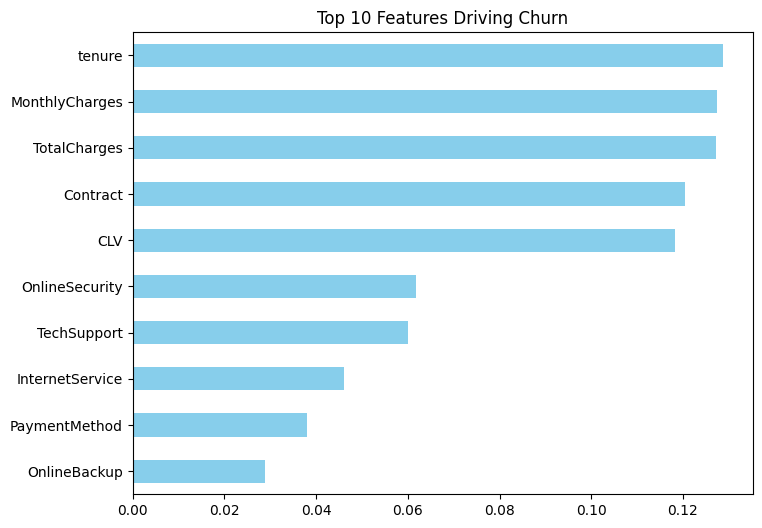

In [19]:
# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

# Plot top features
plt.figure(figsize=(8,6))
importances.tail(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Features Driving Churn')
plt.show()

In [20]:
#revenue lekage analysis
# Revenue at Risk
df['RevenueAtRisk'] = df['MonthlyCharges'] * df['Churn']
total_revenue_leakage = df['RevenueAtRisk'].sum()
print("Total Revenue at Risk: $", total_revenue_leakage)

# High-Value Churn Customers
high_value_churn = df[(df['Churn'] == 1) & (df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75))]
high_value_churn[['MonthlyCharges','tenure','CLV']].head()

Total Revenue at Risk: $ 139130.84999999998


,MonthlyCharges,tenure,CLV
5,99.65,8,797.20
8,104.80,28,2934.40
13,103.70,49,5081.30
26,99.35,47,4669.45
38,106.35,34,3615.90


In [21]:
from google.colab import files
# Strip spaces and make Churn consistent
df['Churn'] = df['Churn'].astype(str).str.strip()  # remove leading/trailing spaces
df['Churn'] = df['Churn'].replace({'Yes': 'Yes', 'No': 'No'})  # normalize values
# Export CSV
df.to_csv('processed_telco_churn.csv', index=False)

# Download the file
files.download('processed_telco_churn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Make sure Churn column is string and clean
#df['Churn'] = df['Churn'].astype(str).str.strip()  # remove leading/trailing spaces
#df['Churn'] = df['Churn'].replace({'Yes': 'Yes', 'No': 'No'})  # normalize exact values

# Optional: check unique values to make sure
#print(df['Churn'].unique())

# Re-export the cleaned CSV
#df.to_csv('processed_telco_churn_clean.csv', index=False)
